In [1]:
from spark_utils import SparkSessionContext
from format_data import TARGET_VARIABLE
from pyspark.sql.window import Window
import pyspark.sql.functions as F

with SparkSessionContext() as spark:
    train_data = spark.read.parquet('data/amex-default-prediction/train_data')
    train_labels = spark.read.parquet('data/amex-default-prediction/train_labels')

    window_latest_date_by_id = (
        Window
        .partitionBy('customer_ID')
        .orderBy(F.col('S_2').desc())
        .rangeBetween(
            Window.unboundedPreceding,
            Window.unboundedFollowing,
        )
    )

    train_data_labelled = (
        train_data
        .join(train_labels, on='customer_ID', how='inner')
        .withColumn('S_2_max', F.max('S_2').over(window_latest_date_by_id))
        .withColumn('days_to_S_2_max', F.datediff(end='S_2_max', start='S_2'))
    )
    sample_num_rows = 1000000
    sample_fraction = sample_num_rows / train_data_labelled.count()
    print(f'sample_fraction: {sample_fraction}')

    train_pdf = train_data_labelled.sample(fraction=sample_fraction).toPandas()
    train_pdf_bytes = train_pdf.memory_usage(deep=True).sum()
    print(
        f'train_pdf.memory_usage in megabytes: {train_pdf_bytes / 1048576: .2f}')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/09 12:54:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


sample_fraction: 0.1807843909310595


22/08/09 12:54:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


train_pdf.memory_usage in megabytes:  1459.77


In [2]:
from format_data import CATEGORICAL_VARIABLES, FEATURE_VARIABLES, TARGET_VARIABLE, DATE_VARIABLES, ID_VARIABLES
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

passthrough_features = [
    *ID_VARIABLES,
    *DATE_VARIABLES,
    TARGET_VARIABLE,
    'S_2_max',
    'days_to_S_2_max',
]
numerical_features = list(set(FEATURE_VARIABLES) - set(CATEGORICAL_VARIABLES))
categorical_features = CATEGORICAL_VARIABLES


trf = ColumnTransformer(
    transformers=[
        # name, transformer, columns
        ('', 'passthrough', passthrough_features),
        ('Qtl', QuantileTransformer(), numerical_features),
        ('Ohe', OneHotEncoder(dtype=int, handle_unknown='ignore'), categorical_features),
    ],
    verbose_feature_names_out=False
)
trf.fit(train_pdf)


ColumnTransformer(transformers=[('', 'passthrough',
                                 ['customer_ID', 'S_2', 'target', 'S_2_max',
                                  'days_to_S_2_max']),
                                ('Qtl', QuantileTransformer(),
                                 ['D_69', 'D_86', 'D_84', 'R_16', 'D_78',
                                  'B_32', 'D_128', 'D_77', 'D_81', 'S_16',
                                  'R_22', 'D_82', 'R_6', 'S_11', 'R_23',
                                  'D_132', 'D_102', 'B_16', 'B_33', 'B_26',
                                  'R_20', 'D_93', 'D_131', 'D_61', 'D_130',
                                  'D_58', 'P_4', 'S_27', 'D_76', 'R_11', ...]),
                                ('Ohe',
                                 OneHotEncoder(dtype=<class 'int'>,
                                               handle_unknown='ignore'),
                                 ['B_30', 'B_38', 'D_114', 'D_116', 'D_117',
                                  'D_120', 'D_126', 'D_63', 'D_64', 'D_66',
                                  'D_68'])],
                  verbose_feature_names_out=False)

In [3]:
feature_columns = list(set(trf.get_feature_names_out(train_pdf.columns)) - set(passthrough_features))
len(feature_columns)

232

In [4]:
import pandas as pd

fit_pdf = pd.DataFrame(
    trf.transform(train_pdf),
    columns=trf.get_feature_names_out(train_pdf.columns)
).fillna(0)
print(
    f'Transform shape: {train_pdf.shape} -> {fit_pdf.shape}\n'
    + 'Transformed feature names:\n'
    + ', '.join(trf.get_feature_names_out(train_pdf.columns))
)

Transform shape: (997699, 193) -> (997699, 237)
Transformed feature names:
customer_ID, S_2, target, S_2_max, days_to_S_2_max, D_69, D_86, D_84, R_16, D_78, B_32, D_128, D_77, D_81, S_16, R_22, D_82, R_6, S_11, R_23, D_132, D_102, B_16, B_33, B_26, R_20, D_93, D_131, D_61, D_130, D_58, P_4, S_27, D_76, R_11, B_29, D_124, S_19, R_1, D_91, D_121, B_12, D_46, D_113, B_24, D_87, B_8, D_56, S_7, D_110, S_18, R_27, D_111, D_119, R_2, B_19, D_125, R_7, B_25, D_92, D_127, D_143, D_134, D_43, R_13, S_8, S_22, B_13, B_18, B_27, B_37, D_48, D_145, D_62, D_137, B_11, S_23, D_70, R_25, D_41, B_10, D_89, D_59, R_17, D_60, D_96, D_54, B_1, D_51, R_19, R_28, B_7, B_28, R_10, D_88, S_6, D_53, B_23, D_136, R_3, R_18, D_49, S_26, R_26, S_20, D_105, S_13, B_20, R_24, B_22, S_24, D_140, D_52, S_12, B_14, D_94, B_9, S_17, D_74, P_2, S_3, D_71, S_5, B_5, D_65, D_83, B_40, D_115, D_122, D_104, D_47, R_5, S_9, B_3, D_108, D_80, D_142, D_139, D_106, D_112, R_15, R_4, B_41, D_39, R_9, R_21, D_79, B_6, B_36, R_12

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(len(feature_columns), 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.linear1(torch.sigmoid(x))
        x = self.linear2(torch.sigmoid(x))
        x = self.linear3(torch.sigmoid(x))
        x = self.softplus(x)
        return x

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch

def log_surv(scale: torch.tensor, t: torch.tensor) -> torch.tensor:
    return -t/scale

def log_density(scale: torch.tensor, t: torch.tensor) -> torch.tensor:
    return -torch.log(scale) - t / scale

def nll(scale: torch.tensor, days_to_last_statement: torch.tensor, is_defaulted: torch.tensor):
    return -torch.mean(torch.where(
        is_defaulted, 
        log_density(scale=scale, t=days_to_last_statement),
        log_surv(scale=scale, t=days_to_last_statement),
    ))

In [7]:
import torch.optim as optim
import numpy as np

m = Model()
optimizer = optim.Adam(m.parameters())

for i in range(1000):
    fit_pdf_small = fit_pdf.sample(10000, ignore_index=True)

    inputs = torch.tensor(np.array(fit_pdf_small[feature_columns])).float()
    days_to_last_statement = torch.tensor(fit_pdf_small['days_to_S_2_max']).reshape((-1, 1)).float()
    is_defaulted = torch.tensor(fit_pdf_small[TARGET_VARIABLE] == 1.).reshape((-1, 1))

    optimizer.zero_grad()
    rate = m(torch.nan_to_num(inputs))
    loss = nll(rate, days_to_last_statement, is_defaulted)
    if i % 25 == 0:
        print(i, loss.item())

    # torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1.)
    loss.backward()
    optimizer.step()


0 197.34136962890625
25 134.53286743164062
50 117.17635345458984
75 106.55329895019531
100 99.89532470703125
125 92.96701049804688
150 88.06147766113281
175 82.30079650878906
200 79.21365356445312
225 76.15546417236328
250 72.36813354492188
275 69.11006164550781
300 67.17908477783203
325 64.99711608886719
350 63.3442497253418
375 61.31256866455078
400 59.090179443359375
425 58.2453498840332
450 56.320892333984375
475 54.26259994506836
500 53.38283920288086
525 52.31086730957031
550 50.67742919921875
575 50.07609176635742
600 48.63405227661133
625 47.71711730957031
650 47.32984924316406
675 46.46696853637695
700 45.22964096069336
725 44.517494201660156
750 44.02064514160156
775 43.27619552612305
800 42.92375946044922
825 42.431312561035156
850 40.951717376708984
875 40.98512649536133
900 39.7378044128418
925 39.33896255493164
950 38.707313537597656
975 38.5063362121582


In [8]:
from format_data import PREDICTION_VARIABLE
import pandas as pd

with torch.no_grad():
    inputs = torch.tensor(np.array(fit_pdf[feature_columns])).float()
    rate = np.array(m(torch.nan_to_num(inputs))).flatten()
    pred_df = pd.DataFrame({
        PREDICTION_VARIABLE: rate,
        'customer_ID': fit_pdf['customer_ID'],
        'S_2': fit_pdf['S_2'],
        'S_2_max': fit_pdf['S_2_max'],
    })

In [9]:
y_pred = pred_df.loc[pred_df['S_2'] == pred_df['S_2_max']].reset_index(drop=True)
y_pred = y_pred[['customer_ID', PREDICTION_VARIABLE]]
y_pred

,customer_ID,prediction
0,00d769dbf0a5e3e73a8223566b33adc5686954dd337359...,4.701720
1,01439ee3abf1b4552d54f75cc46d18e1f9d4aed4b816de...,4.701695
2,01500e2a9f82cfab49e8abb8ebf2101abea15287012509...,4.701704
3,017c62c2d536df82410d9f3427c2da1f8d3c277efe592b...,4.701714
4,01f3396eacb7b77bae4ed9058ac5e596ea33b921b89509...,4.701694
...,...,...
83184,ff8c898ca80f20d794e6f5829b26d637c3edd0267f358f...,4.701713
83185,ffa47104b584db6ba11affb18ae14932320bac18bc0226...,4.701720
83186,ffc0893ba6cd0c90d794da28bae8fa810ef9c17db24947...,4.701696
83187,ffd968fe02b1dfa9e26e3369e36e2c5b67fa9d42f9f926...,4.701724


In [10]:
y_true = fit_pdf.loc[fit_pdf['S_2'] == fit_pdf['S_2_max']].reset_index(drop=True)
y_true = y_true[['customer_ID', TARGET_VARIABLE]]
y_true

,customer_ID,target
0,00d769dbf0a5e3e73a8223566b33adc5686954dd337359...,0.0
1,01439ee3abf1b4552d54f75cc46d18e1f9d4aed4b816de...,0.0
2,01500e2a9f82cfab49e8abb8ebf2101abea15287012509...,0.0
3,017c62c2d536df82410d9f3427c2da1f8d3c277efe592b...,0.0
4,01f3396eacb7b77bae4ed9058ac5e596ea33b921b89509...,1.0
...,...,...
83184,ff8c898ca80f20d794e6f5829b26d637c3edd0267f358f...,0.0
83185,ffa47104b584db6ba11affb18ae14932320bac18bc0226...,1.0
83186,ffc0893ba6cd0c90d794da28bae8fa810ef9c17db24947...,0.0
83187,ffd968fe02b1dfa9e26e3369e36e2c5b67fa9d42f9f926...,1.0


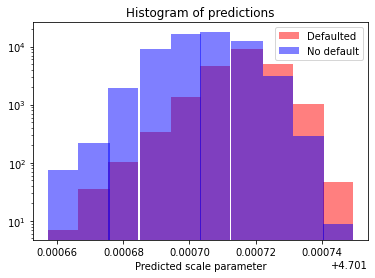

In [11]:
import matplotlib.pyplot as plt

n, bins, array = plt.hist(
    y_pred.loc[y_true[TARGET_VARIABLE] == 1.].reset_index(drop=True)[PREDICTION_VARIABLE],
    color=(1, 0, 0, .5),
    log=True,
    label='Defaulted'
)
n, bins, array = plt.hist(
    y_pred.loc[y_true[TARGET_VARIABLE] == 0.].reset_index(drop=True)[PREDICTION_VARIABLE],
    bins=bins,
    color=(0, 0, 1, .5),
    log=True,
    label='No default'
)
plt.xlabel('Predicted scale parameter')
plt.title('Histogram of predictions')
plt.legend()

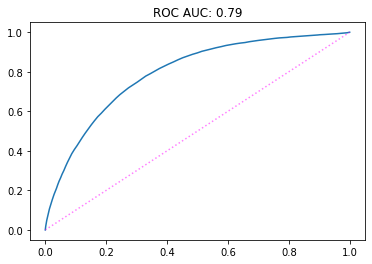

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(
    y_true[TARGET_VARIABLE], 
    y_pred[PREDICTION_VARIABLE],
)
v = roc_auc_score(
    y_true[TARGET_VARIABLE], 
    y_pred[PREDICTION_VARIABLE],
)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls=':', color=(1, 0, 1, .5))
plt.title(f'ROC AUC: {v:.2f}')
plt.show()

In [13]:
y_pred

,customer_ID,prediction
0,00d769dbf0a5e3e73a8223566b33adc5686954dd337359...,4.701720
1,01439ee3abf1b4552d54f75cc46d18e1f9d4aed4b816de...,4.701695
2,01500e2a9f82cfab49e8abb8ebf2101abea15287012509...,4.701704
3,017c62c2d536df82410d9f3427c2da1f8d3c277efe592b...,4.701714
4,01f3396eacb7b77bae4ed9058ac5e596ea33b921b89509...,4.701694
...,...,...
83184,ff8c898ca80f20d794e6f5829b26d637c3edd0267f358f...,4.701713
83185,ffa47104b584db6ba11affb18ae14932320bac18bc0226...,4.701720
83186,ffc0893ba6cd0c90d794da28bae8fa810ef9c17db24947...,4.701696
83187,ffd968fe02b1dfa9e26e3369e36e2c5b67fa9d42f9f926...,4.701724


In [14]:
from evaluation import amex_metric

amex_metric(y_true=y_true[TARGET_VARIABLE], y_pred=y_pred[PREDICTION_VARIABLE])

(0.3987906716579934, 0.585630844608931, 0.2119504987070558)